In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [4]:
import os
from glob import glob

import numpy as np
import utils

from matplotlib import pyplot as plt

COLORS = utils.pascal_color_map()[1:]

/zfs-home/ythu/miniconda3/envs/onevision_ta_2_pseudo_labeling/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...
KMeans fitting complete.


1. Load the data

In [ ]:
# Preapre the data path
DATA_DIR = "./sam3_saco_veval_data" # PUT YOUR DATA PATH HERE
ANNOT_DIR = os.path.join(DATA_DIR, "annotation")

# Load the SACO/Veval annotation files
annot_file_list = glob(os.path.join(ANNOT_DIR, "*veval*.json"))
annot_dfs = utils.get_annot_dfs(file_list=annot_file_list)

100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Show the annotation files being loaded

In [6]:
annot_dfs.keys()

dict_keys(['saco_veval_yt1b_val', 'saco_veval_smartglasses_test', 'saco_veval_yt1b_test', 'saco_veval_sav_val', 'saco_veval_smartglasses_val', 'saco_veval_sav_test'])

2. Examples of the data format

In [7]:
annot_dfs["saco_veval_yt1b_val"].keys()

dict_keys(['info', 'videos', 'annotations', 'categories', 'video_np_pairs'])

In [8]:
annot_dfs["saco_veval_yt1b_val"]["info"]

{'version': 'v1',
 'date': '2025-09-24',
 'description': 'SA-Co/VEval YT-Temporal-1B Val'}

In [9]:
annot_dfs["saco_veval_yt1b_val"]["videos"].head(3)

,id,video_name,file_names,height,width,length
0,0,saco_yt1b_000001,"[saco_yt1b_000001/00000.jpg, saco_yt1b_000001/...",608,1080,53
1,1,saco_yt1b_000002,"[saco_yt1b_000002/00000.jpg, saco_yt1b_000002/...",608,1080,85
2,2,saco_yt1b_000003,"[saco_yt1b_000003/00000.jpg, saco_yt1b_000003/...",608,1080,80


In [10]:
annot_dfs["saco_veval_yt1b_val"]["annotations"].head(3)

,id,segmentations,bboxes,areas,iscrowd,video_id,height,width,category_id,noun_phrase
0,0,[{'counts': 'TS`<6hb06J4K4I7L4K4K5L4LeNb^O\1]a...,"[[673.0, 480.0, 27.0, 52.0], [674.0, 478.0, 28...","[1058.0, 1088.0, 1114.0, 975.0, 973.0, 1028.0,...",0,4,608,1080,8512,a barefoot
1,1,[{'counts': 'klj=5hb05H7H7010O101N1O01O0000000...,"[[745.0, 552.0, 89.0, 37.0], [745.0, 552.0, 89...","[1911.0, 1964.0, 1968.0, 1963.0, 1931.0, 1948....",0,4,608,1080,8512,a barefoot
2,2,[{'counts': 'Vge6:cb05L4L3N2M2M4N2N1N3M2L5N1O1...,"[[359.0, 548.0, 40.0, 55.0], [360.0, 542.0, 40...","[1538.0, 1624.0, 1617.0, 1565.0, 1525.0, 1543....",0,4,608,1080,8512,a barefoot


In [11]:
annot_dfs["saco_veval_yt1b_val"]["categories"].head(3)

,id,name
0,1,a monkey
1,2,a horse
2,3,a fan


In [12]:
annot_dfs["saco_veval_yt1b_val"]["video_np_pairs"].head(3)

,id,video_id,category_id,noun_phrase,num_masklets
0,0,215,48973,the lighthouse,0
1,1,215,49010,a snorkeling mask,0
2,2,321,5402,the flat roof,0


3. Visualize the data

Randomly selected video-np pair: video_id=12, noun_phrase=dog
Reading annotations for frame 0
Reading annotations for frame 4
Reading annotations for frame 8
Reading annotations for frame 12
Reading annotations for frame 16


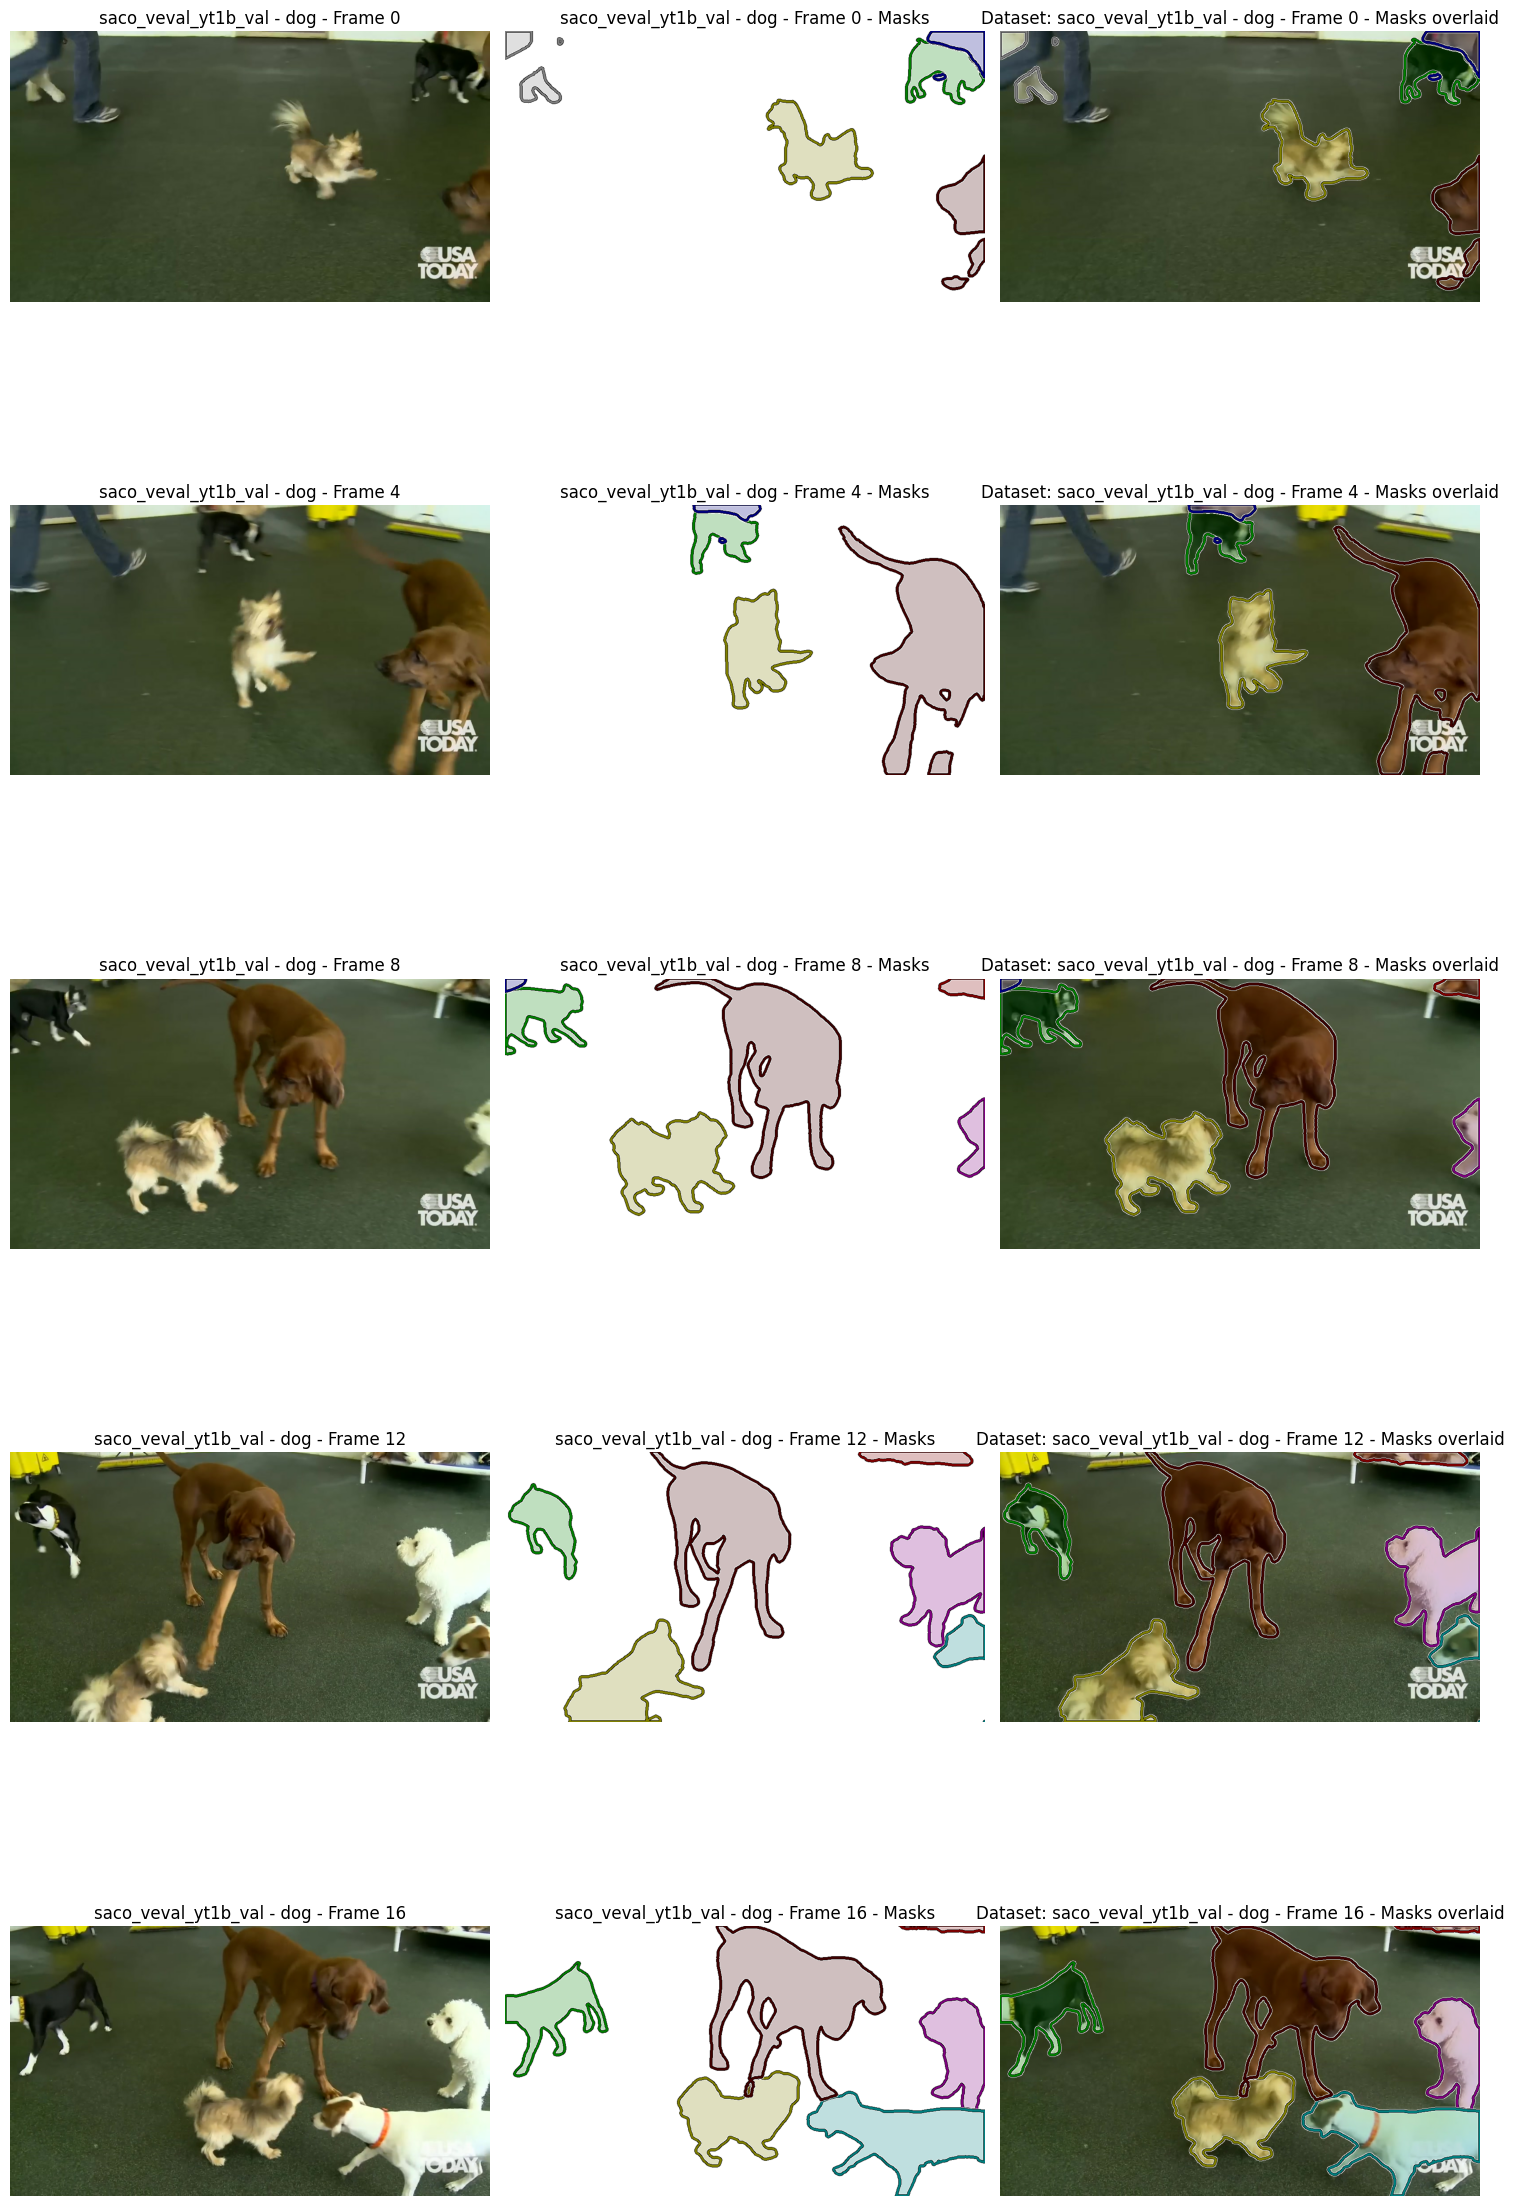

In [13]:
# Select a target dataset
target_dataset_name = "saco_veval_yt1b_val"

# visualize a random positive video-np pair
df_pairs = annot_dfs[target_dataset_name]["video_np_pairs"]
df_positive_pairs = df_pairs[df_pairs.num_masklets > 0]
rand_idx = np.random.randint(len(df_positive_pairs))
rand_idx=100
pair_row = df_positive_pairs.iloc[rand_idx]
video_id = pair_row.video_id
noun_phrase = pair_row.noun_phrase
print(f"Randomly selected video-np pair: video_id={video_id}, noun_phrase={noun_phrase}")

def display_image_in_subplot(img, axes, row, col, title=""):
    axes[row, col].imshow(img)
    axes[row, col].set_title(title)
    axes[row, col].axis('off')

num_frames_to_show = 5  # Number of frames to show per dataset
every_n_frames = 4  # Interval between frames to show

fig, axes = plt.subplots(num_frames_to_show, 3, figsize=(15, 5 * num_frames_to_show))

for idx in range(0, num_frames_to_show):
    sampled_frame_idx = idx * every_n_frames
    print(f"Reading annotations for frame {sampled_frame_idx}")
    # Get the frame and the corresponding masks and noun phrases
    frame, annot_masks, annot_noun_phrases = utils.get_all_annotations_for_frame(
        annot_dfs[target_dataset_name], video_id=video_id, frame_idx=sampled_frame_idx, data_dir=DATA_DIR, dataset=target_dataset_name
    )
    # Filter masks and noun phrases by the selected noun phrase
    annot_masks = [m for m, np in zip(annot_masks, annot_noun_phrases) if np == noun_phrase]

    # Show the frame
    display_image_in_subplot(frame, axes, idx, 0, f"{target_dataset_name} - {noun_phrase} - Frame {sampled_frame_idx}")

    # Show the annotated masks
    if annot_masks is None:
        print(f"No masks found for video_id {video_id} at frame {sampled_frame_idx}")
    else:
        # Show all masks over a white background
        all_masks = utils.draw_masks_to_frame(
            frame=np.ones_like(frame)*255, masks=annot_masks, colors=COLORS[: len(annot_masks)]
        )
        display_image_in_subplot(all_masks, axes, idx, 1, f"{target_dataset_name} - {noun_phrase} - Frame {sampled_frame_idx} - Masks")
        
        # Show masks overlaid on the frame
        masked_frame = utils.draw_masks_to_frame(
            frame=frame, masks=annot_masks, colors=COLORS[: len(annot_masks)]
        )
        display_image_in_subplot(masked_frame, axes, idx, 2, f"Dataset: {target_dataset_name} - {noun_phrase} - Frame {sampled_frame_idx} - Masks overlaid")

plt.tight_layout()
plt.show()